In [8]:
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 70em; }</style>"))

# CARGAR LIBRERIAS
import sys, os

import numpy as np
import pandas as pd

from IPython.display import display
import ipywidgets as wg
import matplotlib.pyplot as plt

In [9]:
# MODELO MATEMATICO

In [10]:
# -*- coding: utf-8 -*-
"""
Created on Mon Mar 15 19:02:08 2021

@author: ICJRC
"""
import numpy as np, sys, pandas as pd

class ModeloSocialZapatosa():
    # PRINCIPAL METHODS
    def __init__(self,
        n_especies = 12,
        n_metodos  = 3,
        dt         = 0.05,
        n_pasostiempo = 14):
        
        '''
        DEFAULT VALUES
        
        n_especies = Numero de especies
        n_metodos  = Numero de artes de pesca
        dt         = paso de tiempo
        n_pasostiempo = numero de pasos de tiempo

        '''
        # data for fix the data
        self.n_especies    = n_especies
        self.n_metodos     = n_metodos
        self.dt            = dt # ano / paso de tiempo
        self.n_pasostiempo = n_pasostiempo
        
        # initial running
        self.t = np.arange(0, n_pasostiempo + dt, dt)
        
        self.LoadParameters()
        self.LoadData()
        self.TestSize()
        
    def __call__(self,
        INIT_HaCult = 20_514,
        INIT_IngA   = 657370.6858244,
        INIT_P      = 149_697,
        INIT_Pp     = 9996.09819207691,
        INIT_Pa     = 98295.0216317322,
        INIT_Pg     = 59118.053513589,
        INIT_G      = 200000.000002635,
        INIT_HaPas  = 218_043.95,
        INIT_Pflot  = 31_596):
        
        '''# MAIN OF THE PROGRAM
        Obj: CORRER MODELO DE ZAPATOZA

        # VARIABLES
        
        INIT_HaCult = Ha de cultivo inicial
        INIT_G      = Cantidad inicial de ganado
        INIT_HaPas  = Ha de pastos inicial
        INIT_P      = Habitante totales inicial
        INIT_Pp     = Poblacion pesquera inicial
        INIT_Pa     = Poblacion agricola inicial
        INIT_Pg     = poblacion ganadera inicial
        INIT_Pflot  = Poblacion flotante inicial
        '''
        
        # SAVE VALUES
        lts_t       = [self.t[0]]
        lts_Ha_Cult = [INIT_HaCult]
        lts_IngA    = [INIT_IngA]
        lts_p       = [INIT_P]
        lts_Pp      = [INIT_Pp]
        lts_Pa      = [INIT_Pa]
        lts_Pg      = [INIT_Pg]
        lts_G       = [INIT_G]
        lts_Hp      = [INIT_HaPas]
        lts_pflot   = [INIT_Pflot]
        
        lts_IngPes  = [np.nan]
        lts_A       = [np.nan]
        lts_IngGan  = [np.nan]
        lts_Pf      = [np.nan]
        
        lts_pes     = [np.nan]
        
        self.__LoadInitialData(INIT_HaCult, INIT_IngA, INIT_P, INIT_Pp, INIT_Pa, INIT_Pg, INIT_G, INIT_HaPas, INIT_Pflot)
        
        t = self.t[0]
        
        for num, tstep in enumerate(self.t[1:]):
            
            dt = tstep - t
            
            # INITIAL
            # Pesca FLOWS
            Disponibilidad = self.dt * self.__disponibilidad()
            pes            = self.dt * self.__pes(Disponibilidad, lts_Pp[-1])
            IngPes         = self.dt * self.__ingPes(pes)
            
            # Agricola FLOWS
            Ha_Cult        = self.__Ha_Cult(INIT_HaCult, dt)
            InvAgr         = self.__invAgr(INIT_IngA)
            A              = self.__Alim(InvAgr, Ha_Cult)
            IngAgr         = self.__IngAgr(A)
            
            # Ganaderia FLOWS
            HaPas, SHaPas  = self.__HaPas(INIT_HaPas, dt)
            
            # # STOKE
            G_i            = self.__G(HaPas, INIT_G, dt)
            IngGan         = self.__IngG(G_i)
            
            # # Poblacion FLOWS
            dpflot_dt, Pflot = self.__pflot(IngGan, IngAgr, IngPes, INIT_Pflot, INIT_Pg, INIT_Pa, INIT_Pp, dt)
            P, dP_dt         = self.__population(INIT_P, dpflot_dt, dt)
            
            Pp, dPp_dt     = self.__pobActiv('-p', IngGan, INIT_Pg, IngAgr, INIT_Pa, IngPes, INIT_Pp, dP_dt, dt)
            Pa, dPa_dt     = self.__pobActiv('-a', IngGan, INIT_Pg, IngAgr, INIT_Pa, IngPes, INIT_Pp, dP_dt, dt)
            Pg, dPg_dt     = self.__pobActiv('-g', IngGan, INIT_Pg, IngAgr, INIT_Pa, IngPes, INIT_Pp, dP_dt, dt)
            
            # # REINITIAL VALUES
            INIT_HaCult = Ha_Cult
            INIT_IngA   = IngAgr  # [COP/ano]
            
            # # Valores iniciales de la poblacion
            INIT_P      = P                # [Hab]
            INIT_Pp     = Pp               # [Hab]
            INIT_Pa     = Pa               # [Hab]
            INIT_Pg     = Pg               # [Hab]
            INIT_HaPas  = SHaPas           # [Ha]
            INIT_Pflot  = Pflot            # [Hab]
            
            # # Valores iniciales de la Actividades economicas
            INIT_G      = G_i               # [cab]
            
            # SAVE VALUES
            lts_t.append(tstep)
            lts_Ha_Cult.append(INIT_HaCult)
            lts_IngA.append(INIT_IngA)
            lts_p.append(INIT_P)
            lts_pflot.append(INIT_Pflot)
            lts_Pp.append(INIT_Pp)
            lts_Pa.append(INIT_Pa)
            lts_Pg.append(INIT_Pg)
            lts_G.append(INIT_G)
            
            lts_IngPes.append(IngPes)
            lts_A.append(A)
            lts_IngGan.append(IngGan)
            lts_Pf.append(dpflot_dt)
            
            lts_pes.append(pes)
            lts_Hp.append(INIT_HaPas)
            
            t = tstep
            
            
        self.RESULT = pd.DataFrame()
        self.RESULT['tiempo'] = self.t
        self.RESULT['Ha_Culti'] = lts_Ha_Cult
        self.RESULT['Ing_Agri'] = lts_IngA
        
        self.RESULT['Poblacio'] = lts_p
        self.RESULT['Pob_Pesq'] = lts_Pp
        self.RESULT['Pob_Agri'] = lts_Pa
        self.RESULT['Pob_Gana'] = lts_Pg
        self.RESULT['Pob_Flotante']=lts_pflot
        
        self.RESULT['C_Ganado'] = lts_G
        
        self.RESULT['Ing_Pesq'] = lts_IngPes
        self.RESULT['Alimento'] = lts_A
        self.RESULT['Ing_Gand'] = lts_IngGan
        self.RESULT['Pob_flot_dpf_dt'] = lts_Pf
        
        self.RESULT['Pesca']    = lts_pes
        self.RESULT['Ha_pasto'] = lts_Hp
        
        self.RESULT = self.RESULT.set_index('tiempo').copy()
        
    # USEFULL METHODS
    
    # HIDEN MODEL METHODS STOKES
    def __G(self, HaPas, Init, dt):
        k1 = self.PARA_theta_16 * HaPas - self.PARA_theta_3 * Init
        k2 = self.PARA_theta_16 * HaPas - self.PARA_theta_3 * (Init + (1 / 2) * k1)
        k3 = self.PARA_theta_16 * HaPas - self.PARA_theta_3 * (Init + (1 / 2) * k2)
        k4 = self.PARA_theta_16 * HaPas - self.PARA_theta_3 * (Init + (1 / 1) * k3)

        dG_dt = (k1 + 2 * k2 + 2 * k3 + k4) / 6
        G_i = self.__correcData(Init + dt * dG_dt)
        return(G_i)
    
    # HIDEN MODEL METHODS FLOWS
    @staticmethod
    def __correcData(num):
        return(0 if num <= 0 else num)
    
    def __Ha_Cult(self, Init, dt):
        k1 = Init * self.DATA_rate_HaCultivos * self.PARA_theta_17
        k2 = (Init + (1 / 2) * k1) * self.DATA_rate_HaCultivos * self.PARA_theta_17
        k3 = (Init + (1 / 2) * k2) * self.DATA_rate_HaCultivos * self.PARA_theta_17
        k4 = (Init + (1 / 1) * k3) * self.DATA_rate_HaCultivos * self.PARA_theta_17
        dHa_Cult_dt = (k1 + 2 * k2 + 2 * k3 + k4) / 6
        
        Ha_Cult = self.__correcData(self.INIT_HaCult + dt * dHa_Cult_dt)

        # Ha_Cult = self.INIT_HaCult + self.INIT_HaCult * self.DATA_rate_HaCultivos * self.PARA_theta_17\
        #     if self.INIT_HaCult + self.INIT_HaCult * self.DATA_rate_HaCultivos * self.PARA_theta_17 >= 0 else 0 
        return(Ha_Cult)
    
    def __pes(self, Disponibilidad, INIT_Pp):
        # Pesca [ton / ano]
        # Flow
        # Supocicion : Se pesca una cantidad independiente de la disponibilidad
        # de peces, esta solo se usa para comparar
        pes = np.minimum(self.PARA_theta_12 * INIT_Pp * self.PARA_theta_20 * self.DATA_ProdMet, Disponibilidad)
        # print ('Se pesca toda la disponibilidad') if (pes == Disponibilidad).all() else None
        return(pes)
    
    def __disponibilidad(self):
        # Disponibilidad para la pesca [ton / ano]
        # Flow
        # Supocicion : Las sanciones afectan independientemente de la especie o
        # la metodologia usada.
        Disponibilidad = self.DATA_DispBiol -  self.PARA_theta_13 * self.DATA_ActIlic * np.ones([self.n_metodos,self.n_especies])
        Disponibilidad[Disponibilidad <= 0] = 0.0
        return(Disponibilidad)
    
    def __HaPas(self, Init, dt):
        # Area disponible para la ganaderia [Ha / ano]
        # Flow
        # Supocicion : El cambio del area de la cienaga solo contribuye o afecta
        # al area para llevar a acabo la ganaderia
        
        k1 =  Init                 * self.DATA_rate_HaPasUS_Ha - self.PARA_theta_15 * self.DATA_HaCienagas * self.DATA_rate_HaCienagas
        k2 = (Init + (1 / 2) * k1) * self.DATA_rate_HaPasUS_Ha - self.PARA_theta_15 * self.DATA_HaCienagas * self.DATA_rate_HaCienagas
        k3 = (Init + (1 / 2) * k2) * self.DATA_rate_HaPasUS_Ha - self.PARA_theta_15 * self.DATA_HaCienagas * self.DATA_rate_HaCienagas
        k4 = (Init + (1 / 1) * k3) * self.DATA_rate_HaPasUS_Ha - self.PARA_theta_15 * self.DATA_HaCienagas * self.DATA_rate_HaCienagas
        
        dHaPas_dt = (k1 + 2 * k2 + 2 * k3 + k4) / 6
        SHaPas = self.__correcData(Init + dt * dHaPas_dt)
        return(dHaPas_dt, SHaPas)
    
    def __invAgr(self, IngA):
        # Inversion realizada en cultivos agricolas [cop / ano]
        # Flow
        InvAgr = self.PARA_theta_14 * IngA
        return(InvAgr)
    
    def __Alim(self, InvAgr, Ha_Cult):
        # Cantidad de alimento cosachado [ton / ano]
        # Flow
        A = self.PARA_theta_10 * Ha_Cult + self.PARA_theta_11 * InvAgr
        return(A)
    
    def __IngAgr(self, A):
        # Ingresos agricolas generados en un ano [cop / ano]
        # Flow
        IngAgr = self.PARA_theta_4 * (1 - self.DATA_PorcAutA) * A
        return(IngAgr)
    
    def __ingPes(self, pes):
        # Ingresos pesqueros generados en un ano [cop / ano]
        # Flow
        IngPes = np.sum((1 - self.PARA_theta_6) * np.sum(self.PARA_theta_5 * pes * (1 - self.DATA_PorcAutP).T, axis=1))
        return(IngPes)
    
    def __IngG(self, G_i):
        IngG = self.PARA_theta_2 * (1 - self.DATA_PorcAutG) * self.PARA_theta_3 * G_i
        return(IngG)
    
    def __pflot(self, IngG, IngA, IngP, Init, InitPg, InitPa, InitPp, dt):
        # [Hab / anio]
        # FLOW
        IngGPP = IngG / int(InitPg) if InitPg > 0 | ~ np.isnan(InitPg) else 0
        IbgAPP = IngA / int(InitPa) if InitPa > 0 | ~ np.isnan(InitPg) else 0
        IngPPP = IngP / int(InitPp) if InitPp > 0 | ~ np.isnan(InitPg) else 0
        
        pflot_in  = self.PARA_theta_1 * ((1/3.) * (IngGPP + IbgAPP + IngPPP))
        pflot_out = self.PARA_theta18 * ((1/3.) * (IngGPP + IbgAPP + IngPPP))
        
        dpflot_dt = dt * (pflot_in - pflot_out)
        
        # STOCK
        Pflot = self.__correcData(Init + dpflot_dt)
        
        return(dpflot_dt, Pflot)
    
    def __population(self, Init, dpf_dt, dt):
        k1 = (Init                  / 1000.) * self.PARA_theta_19 * (self.DATA_nata - self.DATA_mort) + dpf_dt
        k2 = ((Init + (1 / 2) * k1) / 1000.) * self.PARA_theta_19 * (self.DATA_nata - self.DATA_mort) + dpf_dt
        k3 = ((Init + (1 / 2) * k2) / 1000.) * self.PARA_theta_19 * (self.DATA_nata - self.DATA_mort) + dpf_dt
        k4 = ((Init + (1 / 1) * k3) / 1000.) * self.PARA_theta_19 * (self.DATA_nata - self.DATA_mort) + dpf_dt
        
        dP_dt = (k1 + 2 * k2 + 2 * k3 + k4) / 6
        
        P = self.__correcData(Init + dt * dP_dt)
        return(P, dP_dt)
    
    def __pobActiv(self, idAct, IngGan, Pg, 
                                IngAgr, Pa,
                                IngPes, Pp,
                                dP_dt, dt):
        
        if idAct == '-p':
            theta_7 = self.PARA_theta_7_p
            theta_8 = self.PARA_theta_8_p
            IngX     = IngPes
            PorAutoX = self.DATA_PorcAutP.mean()
            Px_ini   = Pp
        elif idAct == '-a':
            theta_7 = self.PARA_theta_7_a
            theta_8 = self.PARA_theta_8_a
            IngX     = IngAgr
            PorAutoX = self.DATA_PorcAutA
            Px_ini   = Pa
        elif idAct == '-g':
            theta_7 = self.PARA_theta_7_g
            theta_8 = self.PARA_theta_8_g
            IngX     = IngGan
            PorAutoX = self.DATA_PorcAutG
            Px_ini   = Pg
        else:
            sys.exit('Non idAct correct')
        
        
        dPx_dt = dP_dt * (theta_7 * 1 / 10_000 * (IngX /(IngGan + IngAgr + IngPes)) + theta_8 \
                        * (PorAutoX /(self.DATA_PorcAutA + self.DATA_PorcAutG + \
                                         self.DATA_PorcAutP.mean())))
            
        Px = self.__correcData(Px_ini + dt * dPx_dt)
        
        return(Px, dPx_dt)
    
    # HIDEN FIX METHODS
    def TestSize(self):
        print('Check VarTest 1') if list(self.PARA_theta_5.shape)   == [self.n_metodos, self.n_especies] else sys.exit('Error en las dimensiones del parametro theta 5 ')
        print('Check VarTest 2') if list(self.PARA_theta_6.shape)   == [self.n_metodos]                  else sys.exit('Error en las dimensiones del parametro theta 6')
        print('Check VarTest 3') if list(self.PARA_theta_12.shape)  == [self.n_metodos, 1]               else sys.exit('Error en las dimensiones del parametro theta 12')
        print('Check VarTest 4') if list(self.DATA_DispBiol.shape)  == [self.n_metodos, self.n_especies] else sys.exit('Error en las dimensiones de la variable DispBiol')
        print('Check VarTest 5') if list(self.DATA_ProdMet.shape)   == [self.n_metodos, self.n_especies] else sys.exit('Error en las dimensiones de la variable ProdMet')
        print('Check VarTest 6') if list(self.DATA_PorcAutP.shape)  == [self.n_especies, 1]              else sys.exit('Error en las dimensiones de la variable PorcAutP')
        
    
    def LoadParameters(self,
        PARA_theta_1 = 2.32958772687529,
        PARA_theta_2 = 518_867.48,
        PARA_theta_3 = 0.053,
        PARA_theta_4 = 2_177_136.22,
        PARA_theta_5 = [1_763_696,
                        0,
                        0,
                        2_882_964.52,
                        0,
                        5_379_272.80,
                        0,
                        0,
                        5_048_579.80,
                        0,
                        0,
                        0],
        PARA_theta_6 = [0.1, 0.1, 0.1],
        PARA_theta_7_p = 4.18932678516848,
        PARA_theta_7_a = 0.150481295033305,
        PARA_theta_7_g = 2.59444606928667,
        PARA_theta_8_p = 9.99173295616787,
        PARA_theta_8_a = 0.103266865037611,
        PARA_theta_8_g = 4.61860246244377,
        PARA_theta_10 = 6.38,
        PARA_theta_11 = 2.5775985054404476e-05, 
        PARA_theta_12 =[[0.20808335798562466],[0.10798605825727428],[0.15628649391145602]],
        PARA_theta_13 = 1.6917563998052831,
        PARA_theta_14 = 6.817035073167162e-06,
        PARA_theta_15 = 0.144281324141783,
        PARA_theta_16 = -0.380984432117318,
        PARA_theta_17 = 4.16810371571129,
        PARA_theta18  = 2.312137453334,
        PARA_theta_19 = 1.15421708263406,
        PARA_theta_20 = 2946.669882718011):
        
        '''
        OBJ : CARGAR LOS PARAMETROS DEL MODELO:
            
        PARA_theta_1 [Hab * Hab / COP]
            
        PARA_theta_2 [COP / Cabeza de ganado]
            
        * PARA_theta_3 [Cab ganado vendida / Cab ganado total * ano]
            
        PARA_theta_4 [COP de venta / ton de alimento]
        
        PARA_theta_5 [COP / ton de pescado]
        
        PARA_theta_6 [COP invertido para realizar un arte de pesca / COP ganado
                      por el arte de pesca]
        
        PARA_theta_7_x [Nuevos Hab debido a los ingresos que se dedican a la 
                        actividad x / Habitantes totales]
        
        PARA_theta_8_x [Nuevos Hab debido a la autoalimentacion que se dedican
                        a la actividad x / Habitantes totales]
        
        * PARA_theta_10 [ton de alimento / ha cultivo * ano]
        
        PARA_theta_11 [ton alimento / COP invertido en la cosecha]
        
        PARA_theta_12 [Hab que usa la metodologia i / Hab dedicado a la pesca]
        
        PARA_theta_13 [ton pescado no desembarcado / Sancion]
        
        PARA_theta_14 [COP invertido en el cultivo / COP ganado por la cosecha]
        
        PARA_theta_15 [Ha pasto / Ha cienaga]
        
        PARA_theta_16 [CAB / Ha pasto]
        
        PARA_theta_17 = Corrector parameter
        
        PARA_theta18  = Porcentaje de la poblacion flotante que se va del sector de estudio
        
        PARA_theta_19 = Correccion de la tasa de natalidad y mortandad
        
        PARA_theta_20 = Correccion de la produtividad de la pesca

        DEFAULT VALUES ---
        
        PARA_theta_1 = 0.01697088609014997,
        PARA_theta_2 = 518_867.48,
        PARA_theta_3 = 0.053,
        PARA_theta_4 = 2_177_136.22,
        PARA_theta_5 = [1_763_696,
                        0,
                        0,
                        2_882_964.52,
                        0,
                        5_379_272.80,
                        0,
                        0,
                        5_048_579.80,
                        0,
                        0,
                        0],
        PARA_theta_6 = [0.1, 0.1, 0.1],
        PARA_theta_7_p = 0.06353198737277023,
        PARA_theta_7_a = 0.15498507367474063,
        PARA_theta_7_g = 0.300061166287696,
        PARA_theta_8_p = 0.14225814250347601,
        PARA_theta_8_a = 0.04061477450613044,
        PARA_theta_8_g = 0.5979137270359538,
        PARA_theta_10 = 6.38,
        PARA_theta_11 = 2.5775985054404476e-05, 
        PARA_theta_12 =[[0.20808335798562466],[0.10798605825727428],[0.15628649391145602]],
        PARA_theta_13 = 1.6917563998052831,
        PARA_theta_14 = 6.817035073167162e-06,
        PARA_theta_15 = 0.07686135601699137,
        PARA_theta_16 = 0.5475852897256095,
        PARA_theta_17 = 0.5446196391537492,
        PARA_theta18  = 0.01695261877625509,
        PARA_theta_19 = 0.03171039088194487,
        PARA_theta_20 = 2946.669882718011

        '''
        self.PARA_theta_1 = PARA_theta_1
        
        self.PARA_theta_2 = PARA_theta_2
        
        self.PARA_theta_3 = self.dt * PARA_theta_3
        
        self.PARA_theta_4 = PARA_theta_4
        
        self.PARA_theta_5 = np.array([PARA_theta_5, ] * self.n_metodos)
        
        self.PARA_theta_6 = np.array(PARA_theta_6)
        
        self.PARA_theta_7_p = PARA_theta_7_p
        self.PARA_theta_7_a = PARA_theta_7_a
        self.PARA_theta_7_g = PARA_theta_7_g
        
        self.PARA_theta_8_p = PARA_theta_8_p
        self.PARA_theta_8_a = PARA_theta_8_a
        self.PARA_theta_8_g = PARA_theta_8_g
        
        self.PARA_theta_10 = self.dt * PARA_theta_10
        
        self.PARA_theta_11 = PARA_theta_11
        
        self.PARA_theta_12 = np.array(PARA_theta_12)
        self.PARA_theta_13 = PARA_theta_13
        
        self.PARA_theta_14 = PARA_theta_14
        
        self.PARA_theta_15 = PARA_theta_15
        
        self.PARA_theta_16 = PARA_theta_16
        
        self.PARA_theta_17 = PARA_theta_17
        
        self.PARA_theta18 = PARA_theta18
        
        self.PARA_theta_19 = PARA_theta_19
        
        self.PARA_theta_20 = PARA_theta_20
        
    def LoadData(self,
        DATA_DispBiol          = [[781.731675,220.870814,220.870814,261.250605,378.703282,217.763466,25.7037613,756.55411,257.24738,1843.69138,186.366998,1338.64745],
                                 [0,0,0,0,0,0,0,0,0,0,0,0],
                                 [0,0,0,0,0,0,0,0,0,0,0,0]],
        DATA_ActIlic           = 1,
        
        DATA_HaPasUS_Ha        = 218_043.95,
        DATA_rate_HaPasUS_Ha   = -0.10066388,
        
        DATA_HaCienagas        = 49_240.391,
        DATA_rate_HaCienagas   = 0.4587,
        
        DATA_ProdMet  = [[0.2416304348	,0.0357065217	,0.5424456522	,0.6743478261	,0.5078804348	,3.1576630435	,2.1968478261	,0.0004891304	,0.532826087	,0.0065217391	,0.0661956522	,0.0407608696],
                         [3.8660869565	,0.5713043478	,8.6791304348	,10.7895652174	,8.1260869565	,50.5226086957	,35.1495652174	,0.007826087	,8.5252173913	,0.1043478261	,1.0591304348	,0.652173913],
                         [7.0072826087	,1.0354891304	,15.730923913	,19.5560869565	,14.7285326087	,91.5722282609	,63.7085869565	,0.0141847826	,15.4519565217	,0.1891304348	,1.919673913	,1.1820652174]],
        DATA_PorcAutA = 0.420897305576836,
        DATA_PorcAutG = 0.444415414264785,
        DATA_PorcAutP = [[0.125],
                        [0.000],
                        [0.000],
                        [0.125],
                        [0.000],
                        [0.125],
                        [0.000],
                        [0.000],
                        [0.15125],
                        [0.000],
                        [0.000],
                        [0.000]],
        DATA_nata = 14.58,
        DATA_mort = 4.56,
        
        DATA_rate_HaCultivos = 0.7253):
        
        ''' CARGAR DATOS DE LA CIENAGA:
        
        PARAMETROS ---
            
        * DATA_DispBiol : Disponibilidad biologica [TON/ANO]
                    |Mojarra amarilla  |-----------------|Chango                |Comelon                |Mojarra Tilapia      |Nicuro        |----------------------|-----------------------|Bocachico             |Bagre rayado                  |Gara Gara               |Arenca
        			|Caquetaia kraussii|Curimata mivartii|Cyphocharax magdalenae|Megaleporinus muyscorum|Oreochromis niloticus|Pimelodus yuma|Plagioscion magdalenae|Potamotrygon magdalenae|Prochilodus magdalenae|Pseudoplatystoma magdaleniatum|Trachelyopterus insignis|Triportheus magdalenae 
        ATARRAYA	|781.731675 	   |220.870814 	     |515.933241 	        |261.250605 	        |378.703282 	      |217.763466 	 |25.7037613 	        |756.55411 	            |257.24738 	           |1843.69138 	                  |186.366998 	           |1338.64745 
        CHINCHORRO	|     0            |     0           |     0                |     0                 |     0               |     0        |     0                |     0                 |     0                |     0                        |     0                  |     0                      
        OTROS    	|     0            |     0           |     0                |     0                 |     0               |     0        |     0                |     0                 |     0                |     0                        |     0                  |     0                          
        
        * DATA_ActIlic : Actividad ilicita (Sanciones / Ano)
        
        DATA_HaPasUS_Ha: Area de pastos del sector a analizar [Ha pasto]
        
        * DATA_rate_HaPasUS_Ha : Tasa de cambio del area de pasto 
        [Ha pasto cambian/ha pasto * ano]
        
        * DATA_HaCienagas: Area de cienagas del sector a analizar [Ha agua]
        
        * DATA_rate_HaCienagas : Tasa de cambio del area de cienagas 
        [Ha agua cambian/ha agua * ano]
        
        * DATA_ProdMet : Produccion de la pesca por cada metodologia y para cada 
        especie [Ton / Hab * ano]
        
        DATA_PorcAutA : Porcentaje de autoconsumo de la produccion agricola 
        [ton / ton]
        
        DATA_PorcAutG : Porcentaje de autoconsumo de la produccion ganadera 
        [cab / cab]
        
        DATA_PorcAutP : Porcentaje de autoconsumo de la produccion pesquera 
        [Ton / Ton]
        
        * DATA_nata : Tasa de natalidad [1000 hab / ano]
        
        * DATA_mort : Tasa de mortalidad [1000 hab / ano]
        
        DEFAULT VALUES ---
        
        DATA_DispBiol          = [[781.731675,220.870814,220.870814,261.250605,378.703282,217.763466,25.7037613,756.55411,257.24738,1843.69138,186.366998,1338.64745],
                                 [0,0,0,0,0,0,0,0,0,0,0,0],
                                 [0,0,0,0,0,0,0,0,0,0,0,0]],
        DATA_ActIlic           = 1,
        
        DATA_HaPasUS_Ha        = 218_043.95,
        DATA_rate_HaPasUS_Ha   = -0.05066388,
        
        DATA_HaCienagas        = 49_240.391,
        DATA_rate_HaCienagas   = 0.4587,
        
        DATA_ProdMet  = [[0.2416304348	,0.0357065217	,0.5424456522	,0.6743478261	,0.5078804348	,3.1576630435	,2.1968478261	,0.0004891304	,0.532826087	,0.0065217391	,0.0661956522	,0.0407608696],
                         [3.8660869565	,0.5713043478	,8.6791304348	,10.7895652174	,8.1260869565	,50.5226086957	,35.1495652174	,0.007826087	,8.5252173913	,0.1043478261	,1.0591304348	,0.652173913],
                         [7.0072826087	,1.0354891304	,15.730923913	,19.5560869565	,14.7285326087	,91.5722282609	,63.7085869565	,0.0141847826	,15.4519565217	,0.1891304348	,1.919673913	,1.1820652174]],
        DATA_PorcAutA = 0.37620352128186463,
        DATA_PorcAutG = 0.08585747030620694,
        DATA_PorcAutP = [[0.125],
                        [0.000],
                        [0.000],
                        [0.125],
                        [0.000],
                        [0.125],
                        [0.000],
                        [0.000],
                        [0.15125],
                        [0.000],
                        [0.000],
                        [0.000]],
        DATA_nata = 14.58,
        DATA_mort = 4.56,
        
        DATA_rate_HaCultivos = 0.7253
        
        '''
        
        self.DATA_DispBiol          = np.array(DATA_DispBiol)
        
        self.DATA_ActIlic           = DATA_ActIlic
        
        self.DATA_HaPasUS_Ha        = DATA_HaPasUS_Ha
        self.DATA_rate_HaPasUS_Ha   = DATA_rate_HaPasUS_Ha
        
        self.DATA_HaCienagas        = DATA_HaCienagas
        self.DATA_rate_HaCienagas   = DATA_rate_HaCienagas
        
        self.DATA_ProdMet           = np.array(DATA_ProdMet)
        
        self.DATA_PorcAutA          = DATA_PorcAutA
        self.DATA_PorcAutG          = DATA_PorcAutG
        
        self.DATA_PorcAutP          = np.array(DATA_PorcAutP)
        
        self.DATA_nata              = DATA_nata
        
        self.DATA_mort              = DATA_mort
        
        self.DATA_rate_HaCultivos   = DATA_rate_HaCultivos
    
    def __LoadInitialData(self, INIT_HaCult, INIT_P, INIT_HaPas, INIT_Pflot,
                          INIT_G, INIT_IngA , INIT_Pp, INIT_Pa,
                          INIT_Pg):
        '''
        DEFAULT VALUES
        INIT_IngA = 839208451.7240292, 
        INIT_Pp = 7158.45484151997,
        INIT_Pa = 95416.55349237971,
        INIT_Pg = 31000.22427019107
        '''
        # Valores iniciales Agricolas
        self.INIT_HaCult = INIT_HaCult # [Ha]
        self.INIT_HaPas  = INIT_HaPas # [Ha]
        self.INIT_IngA   = INIT_IngA  # [COP/ano]
        
        # Valores iniciales de la poblacion
        self.INIT_P      = INIT_P    # [Hab]
        self.INIT_Pp     = INIT_Pp   # [Hab]
        self.INIT_Pa     = INIT_Pa   # [Hab]
        self.INIT_Pg     = INIT_Pg   # [Hab]
        self.INIT_Pflot  = INIT_Pflot
        
        # Valores iniciales de la Actividades economicas
        self.INIT_G      = INIT_G    # [cab]

## Modelo social Zapatosa

A continuación se presenta el modelo matematico que representa el modelo social de la cienaga Zapatosa en Colombia. Este se basa en el diagrama causal desarrollado para este fin. El cual se presenta a continuación.
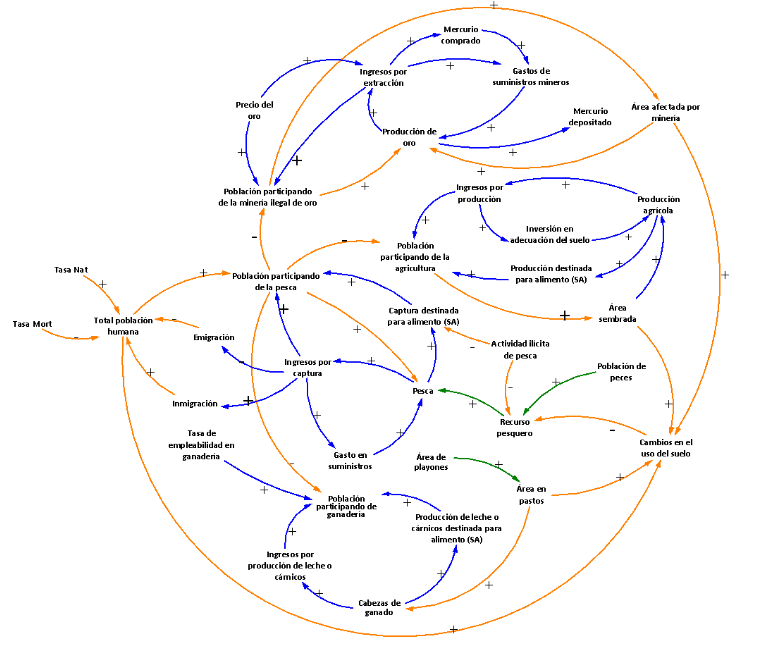

In [11]:
def modelInitial():
    global model, dt, end_time, n_especies, n_artes, initYear
    ''' EL ESQUEMA VISUAL SOLO FUNCIONA PARA 13 ESPECIES DE PECES Y
    PARA 3 ARTES DE PESCA. SIN EMBARGO, EL CODIGO FUNCIONA PARA DIFERENTES
    CANTIDADES DE ESPECIES Y ARTES DE PESCA'''
    print('Paso 2. Escriba los valores globales del modelo: ')
    dt           = float(input('Paso de tiempo [año]: '))
    n_pasotiempo = int(input('Cantidad de años a modelar [año]: '))
    n_especies   = int(input('Cantidad de especies a modelar : '))
    n_metodos    = int(input('Cantidad de artes pesqueras a modelar: '))
    initYear     = int(input('Año inicial de modelación: '))
    
    model = ModeloSocialZapatosa(dt = dt,
                n_pasostiempo = n_pasotiempo,
                n_especies = 12,
                n_metodos = 3)

def run(INIT_HaCult,
        INIT_IngA,  
        INIT_P,     
        INIT_Pp,    
        INIT_Pa,    
        INIT_Pg,    
        INIT_G,     
        INIT_HaPas, 
        INIT_Pflot,
        
        DATA_ActIlic,
        DATA_HaPasUS_Ha,
        DATA_rate_HaPasUS_Ha,
        DATA_HaCienagas,
        DATA_rate_HaCienagas,
        DATA_PorcAutA,
        DATA_PorcAutG,
        DATA_nata,
        DATA_mort,
        DATA_rate_HaCultivos,
        
        i_11_DATA_DispBiol,    
        i_12_DATA_DispBiol,    
        i_13_DATA_DispBiol,    
        i_14_DATA_DispBiol,    
        i_15_DATA_DispBiol,    
        i_16_DATA_DispBiol,    
        i_17_DATA_DispBiol,    
        i_18_DATA_DispBiol,    
        i_19_DATA_DispBiol,    
        i_110_DATA_DispBiol,
        i_111_DATA_DispBiol,   
        i_112_DATA_DispBiol,
        
        i_21_DATA_DispBiol,    
        i_22_DATA_DispBiol,    
        i_23_DATA_DispBiol,    
        i_24_DATA_DispBiol,    
        i_25_DATA_DispBiol,    
        i_26_DATA_DispBiol,    
        i_27_DATA_DispBiol,    
        i_28_DATA_DispBiol,    
        i_29_DATA_DispBiol,    
        i_210_DATA_DispBiol,    
        i_211_DATA_DispBiol,   
        i_212_DATA_DispBiol,
        
        i_31_DATA_DispBiol,    
        i_32_DATA_DispBiol,    
        i_33_DATA_DispBiol,    
        i_34_DATA_DispBiol,    
        i_35_DATA_DispBiol,    
        i_36_DATA_DispBiol,    
        i_37_DATA_DispBiol,    
        i_38_DATA_DispBiol,    
        i_39_DATA_DispBiol,    
        i_310_DATA_DispBiol,    
        i_311_DATA_DispBiol,  
        i_312_DATA_DispBiol,
        
        i_11_DATA_ProMet,
        i_12_DATA_ProMet, 
        i_13_DATA_ProMet, 
        i_14_DATA_ProMet, 
        i_15_DATA_ProMet, 
        i_16_DATA_ProMet, 
        i_17_DATA_ProMet, 
        i_18_DATA_ProMet, 
        i_19_DATA_ProMet, 
        i_110_DATA_ProMet,
        i_111_DATA_ProMet,
        i_112_DATA_ProMet,
        
        i_21_DATA_ProMet, 
        i_22_DATA_ProMet, 
        i_23_DATA_ProMet, 
        i_24_DATA_ProMet, 
        i_25_DATA_ProMet, 
        i_26_DATA_ProMet, 
        i_27_DATA_ProMet, 
        i_28_DATA_ProMet, 
        i_29_DATA_ProMet, 
        i_210_DATA_ProMet,
        i_211_DATA_ProMet,
        i_212_DATA_ProMet,
        
        i_31_DATA_ProMet, 
        i_32_DATA_ProMet, 
        i_33_DATA_ProMet, 
        i_34_DATA_ProMet, 
        i_35_DATA_ProMet, 
        i_36_DATA_ProMet, 
        i_37_DATA_ProMet, 
        i_38_DATA_ProMet, 
        i_39_DATA_ProMet, 
        i_310_DATA_ProMet,
        i_311_DATA_ProMet,
        i_312_DATA_ProMet,
        
        i_1_DATA_PorcAutP, 
        i_2_DATA_PorcAutP, 
        i_3_DATA_PorcAutP, 
        i_4_DATA_PorcAutP, 
        i_5_DATA_PorcAutP, 
        i_6_DATA_PorcAutP, 
        i_7_DATA_PorcAutP, 
        i_8_DATA_PorcAutP, 
        i_9_DATA_PorcAutP, 
        i_10_DATA_PorcAutP,
        i_11_DATA_PorcAutP,
        i_12_DATA_PorcAutP,
        
        i_PARATheta_1_00, 
        i_PARATheta_2_00, 
        i_PARATheta_3_00, 
        i_PARATheta_4_00, 
        i_PARATheta_5_01, 
        i_PARATheta_5_02, 
        i_PARATheta_5_03, 
        i_PARATheta_5_04, 
        i_PARATheta_5_05, 
        i_PARATheta_5_06, 
        i_PARATheta_5_07, 
        i_PARATheta_5_08, 
        i_PARATheta_5_09, 
        i_PARATheta_5_10, 
        i_PARATheta_5_11, 
        i_PARATheta_5_12, 
        i_PARATheta_6_10, 
        i_PARATheta_6_20, 
        i_PARATheta_6_30, 
        i_PARATheta_7_10, 
        i_PARATheta_7_20, 
        i_PARATheta_7_30, 
        i_PARATheta_8_10, 
        i_PARATheta_8_20, 
        i_PARATheta_8_30, 
        i_PARATheta_10,   
        i_PARATheta_11,   
        i_PARATheta_12_10,
        i_PARATheta_12_20,
        i_PARATheta_12_30,
        i_PARATheta_13,   
        i_PARATheta_14,   
        i_PARATheta_15,   
        i_PARATheta_16,   
        i_PARATheta_17,   
        i_PARATheta_18,   
        i_PARATheta_19,   
        i_PARATheta_20   

       ):
    
    global res
    
    model.LoadParameters(
        PARA_theta_1 = i_PARATheta_1_00,
        PARA_theta_2 = i_PARATheta_2_00,
        PARA_theta_3 = i_PARATheta_3_00,
        PARA_theta_4 = i_PARATheta_4_00,
        PARA_theta_5 = [i_PARATheta_5_01,
                        i_PARATheta_5_02,
                        i_PARATheta_5_03,
                        i_PARATheta_5_04,
                        i_PARATheta_5_05,
                        i_PARATheta_5_06,
                        i_PARATheta_5_07,
                        i_PARATheta_5_08,
                        i_PARATheta_5_09,
                        i_PARATheta_5_10,
                        i_PARATheta_5_11,
                        i_PARATheta_5_12],
        
        PARA_theta_6 = [i_PARATheta_6_10, i_PARATheta_6_20, i_PARATheta_6_30],
        PARA_theta_7_p = i_PARATheta_7_10, 
        PARA_theta_7_a = i_PARATheta_7_20,
        PARA_theta_7_g = i_PARATheta_7_30,
        PARA_theta_8_p = i_PARATheta_8_10,
        PARA_theta_8_a = i_PARATheta_8_20,
        PARA_theta_8_g = i_PARATheta_8_30,
        PARA_theta_10 = i_PARATheta_10,
        PARA_theta_11 = i_PARATheta_11, 
        PARA_theta_12 =[[i_PARATheta_12_10],
                        [i_PARATheta_12_20],
                        [i_PARATheta_12_30]],
        PARA_theta_13 = i_PARATheta_13,
        PARA_theta_14 = i_PARATheta_14,
        PARA_theta_15 = i_PARATheta_15,
        PARA_theta_16 = i_PARATheta_16,
        PARA_theta_17 = i_PARATheta_17,
        PARA_theta18  = i_PARATheta_18,
        PARA_theta_19 = i_PARATheta_19,
        PARA_theta_20 = i_PARATheta_20)
    
    model.LoadData(
        DATA_DispBiol            = [[i_11_DATA_DispBiol, i_12_DATA_DispBiol, i_13_DATA_DispBiol, i_14_DATA_DispBiol, i_15_DATA_DispBiol, i_16_DATA_DispBiol,i_17_DATA_DispBiol,i_18_DATA_DispBiol,i_19_DATA_DispBiol,i_110_DATA_DispBiol,i_111_DATA_DispBiol,i_112_DATA_DispBiol],
                                    [i_21_DATA_DispBiol, i_22_DATA_DispBiol, i_23_DATA_DispBiol, i_24_DATA_DispBiol, i_25_DATA_DispBiol, i_26_DATA_DispBiol,i_27_DATA_DispBiol,i_28_DATA_DispBiol,i_29_DATA_DispBiol,i_210_DATA_DispBiol,i_211_DATA_DispBiol,i_212_DATA_DispBiol],
                                    [i_31_DATA_DispBiol, i_32_DATA_DispBiol, i_33_DATA_DispBiol, i_34_DATA_DispBiol, i_35_DATA_DispBiol, i_36_DATA_DispBiol,i_37_DATA_DispBiol,i_38_DATA_DispBiol,i_39_DATA_DispBiol,i_310_DATA_DispBiol,i_311_DATA_DispBiol,i_312_DATA_DispBiol]],
        DATA_ActIlic             = DATA_ActIlic,
        
        DATA_HaPasUS_Ha          = DATA_HaPasUS_Ha,
        DATA_rate_HaPasUS_Ha     = DATA_rate_HaPasUS_Ha,
        
        DATA_HaCienagas          = DATA_HaCienagas,
        DATA_rate_HaCienagas     = DATA_rate_HaCienagas,
        
        DATA_ProdMet             = [[i_11_DATA_ProMet, i_12_DATA_ProMet, i_13_DATA_ProMet, i_14_DATA_ProMet, i_15_DATA_ProMet, i_16_DATA_ProMet,i_17_DATA_ProMet,i_18_DATA_ProMet,i_19_DATA_ProMet,i_110_DATA_ProMet,i_111_DATA_ProMet,i_112_DATA_ProMet],
                                    [i_21_DATA_ProMet, i_22_DATA_ProMet, i_23_DATA_ProMet, i_24_DATA_ProMet, i_25_DATA_ProMet, i_26_DATA_ProMet,i_27_DATA_ProMet,i_28_DATA_ProMet,i_29_DATA_ProMet,i_210_DATA_ProMet,i_211_DATA_ProMet,i_212_DATA_ProMet],
                                    [i_31_DATA_ProMet, i_32_DATA_ProMet, i_33_DATA_ProMet, i_34_DATA_ProMet, i_35_DATA_ProMet, i_36_DATA_ProMet,i_37_DATA_ProMet,i_38_DATA_ProMet,i_39_DATA_ProMet,i_310_DATA_ProMet,i_311_DATA_ProMet,i_312_DATA_ProMet]],
        
        DATA_PorcAutA            = DATA_PorcAutA,
        DATA_PorcAutG            = DATA_PorcAutG,
        
        DATA_PorcAutP            = [[i_1_DATA_PorcAutP],
                                    [i_2_DATA_PorcAutP],
                                    [i_3_DATA_PorcAutP],
                                    [i_4_DATA_PorcAutP],
                                    [i_5_DATA_PorcAutP],
                                    [i_6_DATA_PorcAutP],
                                    [i_7_DATA_PorcAutP],
                                    [i_8_DATA_PorcAutP],
                                    [i_9_DATA_PorcAutP],
                                    [i_10_DATA_PorcAutP],
                                    [i_11_DATA_PorcAutP],
                                    [i_12_DATA_PorcAutP]],
        DATA_nata               = DATA_nata,
        DATA_mort               = DATA_mort,
        
        DATA_rate_HaCultivos    = DATA_rate_HaCultivos)
    
    model(INIT_HaCult = INIT_HaCult,
          INIT_IngA   = INIT_IngA,
          INIT_P      = INIT_P,
          INIT_Pp     = INIT_Pp,
          INIT_Pa     = INIT_Pa,
          INIT_Pg     = INIT_Pg,
          INIT_G      = INIT_G,
          INIT_HaPas  = INIT_HaPas,
          INIT_Pflot  = INIT_Pflot)
    
    res = model.RESULT.copy()
    res.index = res.index + initYear
    
    # plot otras variables
    for name in res.columns:
        if name != 'Pesca':
            res[name].plot()
            plt.title(name)
            plt.grid()
            plt.show()
    
    # plot pesca
    t = res.index.to_list()[1:]
    for especie in range(1, n_especies):
        pesA1 = [res['Pesca'].iloc[tiempo][0][11] for tiempo in range(1, len(res))]
        pesA2 = [res['Pesca'].iloc[tiempo][1][11] for tiempo in range(1, len(res))]
        pesA3 = [res['Pesca'].iloc[tiempo][2][11] for tiempo in range(1, len(res))]
        plt.plot(t, pesA1, label = 'Arte 1')
        plt.plot(t, pesA2, label = 'Arte 2')
        plt.plot(t, pesA3, label = 'Arte 3')
        plt.title('Especie '+str(especie))
        plt.legend()
        plt.grid()
        plt.show()
    
    
def plotDf():
    I_init_HaCult = wg.FloatText(value= 20_514 , description='Área de cultivo inicial Ha')
    I_init_IngA   = wg.FloatText(value= 657370.6858244, description='Ingresos agropecuarios') 
    I_init_P      = wg.FloatText(value= 149_697, description='Población inicial Hab')
    I_init_Pp     = wg.FloatText(value= 9996.09819207691, description='Poblacion de pescadores')
    I_init_Pa     = wg.FloatText(value= 98295.0216317322, description='Poblacion dedicada a la agricultores')
    I_init_Pg     = wg.FloatText(value= 59118.053513589, description='Población dedicada a la ganader')
    I_init_G      = wg.FloatText(value= 200000.000002635, description='Cantidad de ganado')
    I_init_HaPas  = wg.FloatText(value= 218_043.95, description='Áreas de pastos Ha')
    I_init_Pflot  = wg.FloatText(value= 31_596, description='Población flotante Ha')
    
    I_11_DATA_DispBiol        = wg.FloatText(value=781.731675 , description='Disponibilidad biologica especie 1 por la metodologia 1')
    I_12_DATA_DispBiol        = wg.FloatText(value=220.870814 , description='Disponibilidad biologica especie 2 por la metodologia 1')
    I_13_DATA_DispBiol        = wg.FloatText(value=220.870814 , description='Disponibilidad biologica especie 3 por la metodologia 1')
    I_14_DATA_DispBiol        = wg.FloatText(value=261.250605 , description='Disponibilidad biologica especie 4 por la metodologia 1')
    I_15_DATA_DispBiol        = wg.FloatText(value=378.703282 , description='Disponibilidad biologica especie 5 por la metodologia 1')
    I_16_DATA_DispBiol        = wg.FloatText(value=217.763466 , description='Disponibilidad biologica especie 6 por la metodologia 1')
    I_17_DATA_DispBiol        = wg.FloatText(value=25.7037613 , description='Disponibilidad biologica especie 7 por la metodologia 1')
    I_18_DATA_DispBiol        = wg.FloatText(value=756.55411 , description='Disponibilidad biologica especie 8 por la metodologia 1')
    I_19_DATA_DispBiol        = wg.FloatText(value=257.24738 , description='Disponibilidad biologica especie 9 por la metodologia 1')
    I_10_DATA_DispBiol        = wg.FloatText(value=1843.69138 , description='Disponibilidad biologica especie 10 por la metodologia 1')
    I_111_DATA_DispBiol        = wg.FloatText(value=186.366998 , description='Disponibilidad biologica especie 11 por la metodologia 1')
    I_112_DATA_DispBiol        = wg.FloatText(value=1338.64745 , description='Disponibilidad biologica especie 12 por la metodologia 1')
    
    I_21_DATA_DispBiol        = wg.FloatText(value=0 , description='Disponibilidad biologica especie 1 por la metodologia 2')
    I_22_DATA_DispBiol        = wg.FloatText(value=0 , description='Disponibilidad biologica especie 2 por la metodologia 2')
    I_23_DATA_DispBiol        = wg.FloatText(value=0 , description='Disponibilidad biologica especie 3 por la metodologia 2')
    I_24_DATA_DispBiol        = wg.FloatText(value=0 , description='Disponibilidad biologica especie 4 por la metodologia 2')
    I_25_DATA_DispBiol        = wg.FloatText(value=0 , description='Disponibilidad biologica especie 5 por la metodologia 2')
    I_26_DATA_DispBiol        = wg.FloatText(value=0 , description='Disponibilidad biologica especie 6 por la metodologia 2')
    I_27_DATA_DispBiol        = wg.FloatText(value=0 , description='Disponibilidad biologica especie 7 por la metodologia 2')
    I_28_DATA_DispBiol        = wg.FloatText(value=0 , description='Disponibilidad biologica especie 8 por la metodologia 2')
    I_29_DATA_DispBiol        = wg.FloatText(value=0 , description='Disponibilidad biologica especie 9 por la metodologia 2')
    I_20_DATA_DispBiol        = wg.FloatText(value=0 , description='Disponibilidad biologica especie 10 por la metodologia 2')
    I_211_DATA_DispBiol        = wg.FloatText(value=0 , description='Disponibilidad biologica especie 11 por la metodologia 2')
    I_212_DATA_DispBiol        = wg.FloatText(value=0 , description='Disponibilidad biologica especie 12 por la metodologia 2')
    
    I_31_DATA_DispBiol        = wg.FloatText(value=0 , description='Disponibilidad biologica especie 1 por la metodologia 3')
    I_32_DATA_DispBiol        = wg.FloatText(value=0 , description='Disponibilidad biologica especie 2 por la metodologia 3')
    I_33_DATA_DispBiol        = wg.FloatText(value=0 , description='Disponibilidad biologica especie 3 por la metodologia 3')
    I_34_DATA_DispBiol        = wg.FloatText(value=0 , description='Disponibilidad biologica especie 4 por la metodologia 3')
    I_35_DATA_DispBiol        = wg.FloatText(value=0 , description='Disponibilidad biologica especie 5 por la metodologia 3')
    I_36_DATA_DispBiol        = wg.FloatText(value=0 , description='Disponibilidad biologica especie 6 por la metodologia 3')
    I_37_DATA_DispBiol        = wg.FloatText(value=0 , description='Disponibilidad biologica especie 7 por la metodologia 3')
    I_38_DATA_DispBiol        = wg.FloatText(value=0 , description='Disponibilidad biologica especie 8 por la metodologia 3')
    I_39_DATA_DispBiol        = wg.FloatText(value=0 , description='Disponibilidad biologica especie 9 por la metodologia 3')
    I_30_DATA_DispBiol        = wg.FloatText(value=0 , description='Disponibilidad biologica especie 10 por la metodologia 3')
    I_311_DATA_DispBiol        = wg.FloatText(value=0 , description='Disponibilidad biologica especie 11 por la metodologia 3')
    I_312_DATA_DispBiol        = wg.FloatText(value=0 , description='Disponibilidad biologica especie 12 por la metodologia 3')
    
    I_11_DATA_ProMet = wg.FloatText(value=0.2416304348,description='Productividad de la especie 1 por la metodologia 1')
    I_12_DATA_ProMet = wg.FloatText(value=0.0357065217,description='Productividad de la especie 2 por la metodologia 1')
    I_13_DATA_ProMet = wg.FloatText(value=0.5424456522,description='Productividad de la especie 3 por la metodologia 1')
    I_14_DATA_ProMet = wg.FloatText(value=0.6743478261,description='Productividad de la especie 4 por la metodologia 1')
    I_15_DATA_ProMet = wg.FloatText(value=0.5078804348,description='Productividad de la especie 5 por la metodologia 1')
    I_16_DATA_ProMet = wg.FloatText(value=3.1576630435,description='Productividad de la especie 6 por la metodologia 1')
    I_17_DATA_ProMet = wg.FloatText(value=2.1968478261,description='Productividad de la especie 7 por la metodologia 1')
    I_18_DATA_ProMet = wg.FloatText(value=0.0004891304,description='Productividad de la especie 8 por la metodologia 1')
    I_19_DATA_ProMet = wg.FloatText(value=0.532826087,description='Productividad de la especie 9 por la metodologia 1')
    I_110_DATA_ProMet = wg.FloatText(value=0.0065217391,description='Productividad de la especie 10 por la metodologia 1')
    I_111_DATA_ProMet = wg.FloatText(value=0.0661956522,description='Productividad de la especie 11 por la metodologia 1')
    I_112_DATA_ProMet = wg.FloatText(value=0.0407608696,description='Productividad de la especie 12 por la metodologia 1')
    
    I_21_DATA_ProMet = wg.FloatText(value=3.8660869565,description='Productividad de la especie 1 por la metodologia 2')
    I_22_DATA_ProMet = wg.FloatText(value=0.5713043478,description='Productividad de la especie 2 por la metodologia 2')
    I_23_DATA_ProMet = wg.FloatText(value=8.6791304348,description='Productividad de la especie 3 por la metodologia 2')
    I_24_DATA_ProMet = wg.FloatText(value=10.7895652174,description='Productividad de la especie 4 por la metodologia 2')
    I_25_DATA_ProMet = wg.FloatText(value=8.1260869565,description='Productividad de la especie 5 por la metodologia 2')
    I_26_DATA_ProMet = wg.FloatText(value=50.5226086957,description='Productividad de la especie 6 por la metodologia 2')
    I_27_DATA_ProMet = wg.FloatText(value=35.1495652174,description='Productividad de la especie 7 por la metodologia 2')
    I_28_DATA_ProMet = wg.FloatText(value=0.007826087,description='Productividad de la especie 8 por la metodologia 2')
    I_29_DATA_ProMet = wg.FloatText(value=8.5252173913,description='Productividad de la especie 9 por la metodologia 2')
    I_210_DATA_ProMet = wg.FloatText(value=0.1043478261,description='Productividad de la especie 10 por la metodologia 2')
    I_211_DATA_ProMet = wg.FloatText(value=1.0591304348,description='Productividad de la especie 12 por la metodologia 2')
    I_212_DATA_ProMet = wg.FloatText(value=0.652173913,description='Productividad de la especie 12 por la metodologia 2')
    
    I_31_DATA_ProMet = wg.FloatText(value=7.0072826087,description='Productividad de la especie 1 por la metodologia 3')
    I_32_DATA_ProMet = wg.FloatText(value=1.0354891304,description='Productividad de la especie 2 por la metodologia 3')
    I_33_DATA_ProMet = wg.FloatText(value=15.730923913,description='Productividad de la especie 3 por la metodologia 3')
    I_34_DATA_ProMet = wg.FloatText(value=19.5560869565,description='Productividad de la especie 4 por la metodologia 3')
    I_35_DATA_ProMet = wg.FloatText(value=14.7285326087,description='Productividad de la especie 5 por la metodologia 3')
    I_36_DATA_ProMet = wg.FloatText(value=91.5722282609,description='Productividad de la especie 6 por la metodologia 3')
    I_37_DATA_ProMet = wg.FloatText(value=63.7085869565,description='Productividad de la especie 7 por la metodologia 3')
    I_38_DATA_ProMet = wg.FloatText(value=0.0141847826,description='Productividad de la especie 8 por la metodologia 3')
    I_39_DATA_ProMet = wg.FloatText(value=15.4519565217,description='Productividad de la especie 9 por la metodologia 3')
    I_310_DATA_ProMet = wg.FloatText(value=0.1891304348,description='Productividad de la especie 10 por la metodologia 3')
    I_311_DATA_ProMet = wg.FloatText(value=1.919673913,description='Productividad de la especie 11 por la metodologia 3')
    I_312_DATA_ProMet = wg.FloatText(value=1.1820652174,description='Productividad de la especie 12 por la metodologia 3')
    
    I_DATA_ActIlic         = wg.FloatText(value=1 , description='Actividades ilicitas')
    I_DATA_HaPasUS_Ha      = wg.FloatText(value=218_043.95 , description='Hectareas de pasto')
    I_DATA_rate_HaPasUS_Ha = wg.FloatText(value=-0.10066388 , description='Tasa de cambio de pastos')
    I_DATA_HaCienagas      = wg.FloatText(value=49_240.391 , description='Hectareas de cienagas')
    I_DATA_rate_HaCienagas = wg.FloatText(value=0.4587 , description='Tasa de cambios de cienagas')
    
    I_DATA_PorcAutA        = wg.FloatText(value= 0.420897305576836, description='% autoconsumo Agricola')
    I_DATA_PorcAutG        = wg.FloatText(value= 0.444415414264785, description='% autoconsumo Ganadero')
    
    I_1_DATA_PorcAutP        = wg.FloatText(value=0.125, description='% autoconsumo especie 1')
    I_2_DATA_PorcAutP        = wg.FloatText(value=0.000,description='% autoconsumo especie 2')
    I_3_DATA_PorcAutP        = wg.FloatText(value=0.000,description='% autoconsumo especie 3')
    I_4_DATA_PorcAutP        = wg.FloatText(value=0.125,description='% autoconsumo especie 4')
    I_5_DATA_PorcAutP        = wg.FloatText(value=0.000,description='% autoconsumo especie 5')
    I_6_DATA_PorcAutP        = wg.FloatText(value=0.125,description='% autoconsumo especie 6')
    I_7_DATA_PorcAutP        = wg.FloatText(value=0.000,description='% autoconsumo especie 7')
    I_8_DATA_PorcAutP        = wg.FloatText(value=0.000,description='% autoconsumo especie 8')
    I_9_DATA_PorcAutP      = wg.FloatText(value=0.15125,description='% autoconsumo especie 9')
    I_10_DATA_PorcAutP       = wg.FloatText(value=0.000,description='% autoconsumo especie 10')
    I_11_DATA_PorcAutP       = wg.FloatText(value=0.000,description='% autoconsumo especie 11')
    I_12_DATA_PorcAutP       = wg.FloatText(value=0.000,description='% autoconsumo especie 12')
    
    I_DATA_nata            = wg.FloatText(value= 14.58, description='Tasa de natalidad')
    I_DATA_mort            = wg.FloatText(value= 4.56, description='Tasa de mortalidad')
    I_DATA_rate_HaCultivos = wg.FloatText(value= 0.7253, description='Tasa de cambio de cultivos')
        
    I_PARATheta_1_00 = wg.FloatText(value= 2.32958772687529, description='parametro theta 1')
    I_PARATheta_2_00 = wg.FloatText(value= 518_867.48, description='parametro theta 2')
    I_PARATheta_3_00 = wg.FloatText(value= 0.053, description='parametro theta 3')
    I_PARATheta_4_00 = wg.FloatText(value= 2_177_136.22, description='parametro theta 4')
    
    I_PARATheta_5_01 = wg.FloatText(value= 1_763_696.22, description='parametro theta 5 - especie 1')
    I_PARATheta_5_02 = wg.FloatText(value= 0, description='parametro theta 5 - especie 2')
    I_PARATheta_5_03 = wg.FloatText(value= 0, description='parametro theta 5 - especie 3')
    I_PARATheta_5_04 = wg.FloatText(value= 2_882_964.52, description='parametro theta 5 - especie 4')
    I_PARATheta_5_05 = wg.FloatText(value= 0, description='parametro theta 5 - especie 5')
    I_PARATheta_5_06 = wg.FloatText(value= 5_379_272.80, description='parametro theta 5 - especie 6')
    I_PARATheta_5_07 = wg.FloatText(value= 0, description='parametro theta 5 - especie 7')
    I_PARATheta_5_08 = wg.FloatText(value= 0, description='parametro theta 5 - especie 8')
    I_PARATheta_5_09 = wg.FloatText(value= 5_048_579.80, description='parametro theta 5 - especie 9')
    I_PARATheta_5_10 = wg.FloatText(value= 0, description='parametro theta 5 - especie 10')
    I_PARATheta_5_11 = wg.FloatText(value= 0, description='parametro theta 5 - especie 11')
    I_PARATheta_5_12 = wg.FloatText(value= 0, description='parametro theta 5 - especie 12')
    
    I_PARATheta_6_10 = wg.FloatText(value= 0.1, description='parametro theta 6 - Arte 1')
    I_PARATheta_6_20 = wg.FloatText(value= 0.1, description='parametro theta 6 - Arte 2')
    I_PARATheta_6_30 = wg.FloatText(value= 0.1, description='parametro theta 6 - Arte 3')
    
    I_PARATheta_7_10 = wg.FloatText(value= 4.18932678516848, description='parametro theta 7 - Pesca')
    I_PARATheta_7_20 = wg.FloatText(value= 0.150481295033305, description='parametro theta 7 - Agricultura')
    I_PARATheta_7_30 = wg.FloatText(value= 2.59444606928667, description='parametro theta 7 - Ganado')
    
    I_PARATheta_8_10 = wg.FloatText(value= 9.99173295616787, description='parametro theta 8 - Pesca')
    I_PARATheta_8_20 = wg.FloatText(value= 0.103266865037611, description='parametro theta 8 - Agricultura')
    I_PARATheta_8_30 = wg.FloatText(value= 4.61860246244377, description='parametro theta 8 - Ganado')
    
    I_PARATheta_10 = wg.FloatText(value= 6.38, description='parametro theta 10')
    I_PARATheta_11 = wg.FloatText(value= 2.5775985054404476e-05, description='parametro theta 11')
    
    I_PARATheta_12_10 = wg.FloatText(value= 0.20808335798562466, description='parametro theta 12 - Arte 1')
    I_PARATheta_12_20 = wg.FloatText(value= 0.10798605825727428, description='parametro theta 12 - Arte 2')
    I_PARATheta_12_30 = wg.FloatText(value= 0.15628649391145602, description='parametro theta 12 - Arte 3')
    
    I_PARATheta_13 = wg.FloatText(value= 1.6917563998052831, description='parametro theta 13')
    I_PARATheta_14 = wg.FloatText(value= 6.817035073167162e-06, description='parametro theta 14')
    I_PARATheta_15 = wg.FloatText(value= 0.144281324141783, description='parametro theta 15')
    I_PARATheta_16 = wg.FloatText(value= -0.380984432117318, description='parametro theta 16')
    I_PARATheta_17 = wg.FloatText(value= 4.16810371571129, description='parametro theta 17')
    I_PARATheta_18 = wg.FloatText(value= 2.312137453334, description='parametro theta 18')
    I_PARATheta_19 = wg.FloatText(value= 1.15421708263406, description='parametro theta 19')
    I_PARATheta_20 = wg.FloatText(value= 2946.669882718011, description='parametro theta 20')
    
    
    
    wg.interact(run,\
               INIT_HaCult = I_init_HaCult,
               INIT_IngA   = I_init_IngA,
               INIT_P      = I_init_P,
               INIT_Pp     = I_init_Pp,
               INIT_Pa     = I_init_Pa,
               INIT_Pg     = I_init_Pg,
               INIT_G      = I_init_G,
               INIT_HaPas  = I_init_HaPas,
               INIT_Pflot  = I_init_Pflot,
               
               DATA_ActIlic         = I_DATA_ActIlic,
               DATA_HaPasUS_Ha      = I_DATA_HaPasUS_Ha, 
               DATA_rate_HaPasUS_Ha = I_DATA_rate_HaPasUS_Ha,
               DATA_HaCienagas      = I_DATA_HaCienagas,
               DATA_rate_HaCienagas = I_DATA_rate_HaCienagas,
               DATA_PorcAutA        = I_DATA_PorcAutA,
               DATA_PorcAutG        = I_DATA_PorcAutG,
               DATA_nata            = I_DATA_nata,
               DATA_mort            = I_DATA_mort,
               DATA_rate_HaCultivos = I_DATA_rate_HaCultivos,
                
               i_11_DATA_DispBiol = I_11_DATA_DispBiol, 
               i_12_DATA_DispBiol = I_12_DATA_DispBiol, 
               i_13_DATA_DispBiol = I_13_DATA_DispBiol, 
               i_14_DATA_DispBiol = I_14_DATA_DispBiol, 
               i_15_DATA_DispBiol = I_15_DATA_DispBiol, 
               i_16_DATA_DispBiol = I_16_DATA_DispBiol, 
               i_17_DATA_DispBiol = I_17_DATA_DispBiol, 
               i_18_DATA_DispBiol = I_18_DATA_DispBiol, 
               i_19_DATA_DispBiol = I_19_DATA_DispBiol, 
               i_110_DATA_DispBiol = I_10_DATA_DispBiol, 
               i_111_DATA_DispBiol = I_111_DATA_DispBiol,
               i_112_DATA_DispBiol = I_112_DATA_DispBiol,
                
               i_21_DATA_DispBiol = I_21_DATA_DispBiol, 
               i_22_DATA_DispBiol = I_22_DATA_DispBiol, 
               i_23_DATA_DispBiol = I_23_DATA_DispBiol, 
               i_24_DATA_DispBiol = I_24_DATA_DispBiol, 
               i_25_DATA_DispBiol = I_25_DATA_DispBiol, 
               i_26_DATA_DispBiol = I_26_DATA_DispBiol, 
               i_27_DATA_DispBiol = I_27_DATA_DispBiol, 
               i_28_DATA_DispBiol = I_28_DATA_DispBiol, 
               i_29_DATA_DispBiol = I_29_DATA_DispBiol, 
               i_210_DATA_DispBiol = I_20_DATA_DispBiol, 
               i_211_DATA_DispBiol = I_211_DATA_DispBiol,
               i_212_DATA_DispBiol = I_212_DATA_DispBiol,
                
               i_31_DATA_DispBiol = I_31_DATA_DispBiol, 
               i_32_DATA_DispBiol = I_32_DATA_DispBiol, 
               i_33_DATA_DispBiol = I_33_DATA_DispBiol, 
               i_34_DATA_DispBiol = I_34_DATA_DispBiol, 
               i_35_DATA_DispBiol = I_35_DATA_DispBiol, 
               i_36_DATA_DispBiol = I_36_DATA_DispBiol, 
               i_37_DATA_DispBiol = I_37_DATA_DispBiol, 
               i_38_DATA_DispBiol = I_38_DATA_DispBiol, 
               i_39_DATA_DispBiol = I_39_DATA_DispBiol, 
               i_310_DATA_DispBiol = I_30_DATA_DispBiol, 
               i_311_DATA_DispBiol = I_311_DATA_DispBiol,
               i_312_DATA_DispBiol = I_312_DATA_DispBiol,
               
               i_11_DATA_ProMet = I_11_DATA_ProMet,
               i_12_DATA_ProMet = I_12_DATA_ProMet,
               i_13_DATA_ProMet = I_13_DATA_ProMet,
               i_14_DATA_ProMet = I_14_DATA_ProMet,
               i_15_DATA_ProMet = I_15_DATA_ProMet,
               i_16_DATA_ProMet = I_16_DATA_ProMet,
               i_17_DATA_ProMet = I_17_DATA_ProMet,
               i_18_DATA_ProMet = I_18_DATA_ProMet,
               i_19_DATA_ProMet = I_19_DATA_ProMet,
               i_110_DATA_ProMet = I_110_DATA_ProMet,
               i_111_DATA_ProMet = I_111_DATA_ProMet,
               i_112_DATA_ProMet = I_112_DATA_ProMet,
                
               i_21_DATA_ProMet = I_21_DATA_ProMet,
               i_22_DATA_ProMet = I_22_DATA_ProMet,
               i_23_DATA_ProMet = I_23_DATA_ProMet,
               i_24_DATA_ProMet = I_24_DATA_ProMet,
               i_25_DATA_ProMet = I_25_DATA_ProMet,
               i_26_DATA_ProMet = I_26_DATA_ProMet,
               i_27_DATA_ProMet = I_27_DATA_ProMet,
               i_28_DATA_ProMet = I_28_DATA_ProMet,
               i_29_DATA_ProMet = I_29_DATA_ProMet,
               i_210_DATA_ProMet = I_210_DATA_ProMet,
               i_211_DATA_ProMet = I_211_DATA_ProMet,
               i_212_DATA_ProMet = I_212_DATA_ProMet,
                
               i_31_DATA_ProMet = I_31_DATA_ProMet,
               i_32_DATA_ProMet = I_32_DATA_ProMet,
               i_33_DATA_ProMet = I_33_DATA_ProMet,
               i_34_DATA_ProMet = I_34_DATA_ProMet,
               i_35_DATA_ProMet = I_35_DATA_ProMet,
               i_36_DATA_ProMet = I_36_DATA_ProMet,
               i_37_DATA_ProMet = I_37_DATA_ProMet,
               i_38_DATA_ProMet = I_38_DATA_ProMet,
               i_39_DATA_ProMet = I_39_DATA_ProMet,
               i_310_DATA_ProMet = I_310_DATA_ProMet,
               i_311_DATA_ProMet = I_311_DATA_ProMet,
               i_312_DATA_ProMet = I_312_DATA_ProMet,
               
               i_1_DATA_PorcAutP = I_1_DATA_PorcAutP,
               i_2_DATA_PorcAutP = I_2_DATA_PorcAutP,
               i_3_DATA_PorcAutP = I_3_DATA_PorcAutP,
               i_4_DATA_PorcAutP = I_4_DATA_PorcAutP,
               i_5_DATA_PorcAutP = I_5_DATA_PorcAutP,
               i_6_DATA_PorcAutP = I_6_DATA_PorcAutP,
               i_7_DATA_PorcAutP = I_7_DATA_PorcAutP,
               i_8_DATA_PorcAutP = I_8_DATA_PorcAutP,
               i_9_DATA_PorcAutP = I_9_DATA_PorcAutP,
               i_10_DATA_PorcAutP = I_10_DATA_PorcAutP,
               i_11_DATA_PorcAutP = I_11_DATA_PorcAutP,
               i_12_DATA_PorcAutP = I_12_DATA_PorcAutP,
               
               i_PARATheta_1_00 = I_PARATheta_1_00,
               i_PARATheta_2_00 = I_PARATheta_2_00,
               i_PARATheta_3_00 = I_PARATheta_3_00,
               i_PARATheta_4_00 = I_PARATheta_4_00,
               i_PARATheta_5_01 = I_PARATheta_5_01,
               i_PARATheta_5_02 = I_PARATheta_5_02,
               i_PARATheta_5_03 = I_PARATheta_5_03,
               i_PARATheta_5_04 = I_PARATheta_5_04,
               i_PARATheta_5_05 = I_PARATheta_5_05,
               i_PARATheta_5_06 = I_PARATheta_5_06,
               i_PARATheta_5_07 = I_PARATheta_5_07,
               i_PARATheta_5_08 = I_PARATheta_5_08,
               i_PARATheta_5_09 = I_PARATheta_5_09,
               i_PARATheta_5_10 = I_PARATheta_5_10,
               i_PARATheta_5_11 = I_PARATheta_5_11,
               i_PARATheta_5_12 = I_PARATheta_5_12,
               i_PARATheta_6_10 = I_PARATheta_6_10,
               i_PARATheta_6_20 = I_PARATheta_6_20,
               i_PARATheta_6_30 = I_PARATheta_6_30,
               i_PARATheta_7_10 = I_PARATheta_7_10,
               i_PARATheta_7_20 = I_PARATheta_7_20,
               i_PARATheta_7_30 = I_PARATheta_7_30,
               i_PARATheta_8_10 = I_PARATheta_8_10,
               i_PARATheta_8_20 = I_PARATheta_8_20,
               i_PARATheta_8_30 = I_PARATheta_8_30,
               i_PARATheta_10   =  I_PARATheta_10,
               i_PARATheta_11   = I_PARATheta_11,
               i_PARATheta_12_10 = I_PARATheta_12_10,
               i_PARATheta_12_20 = I_PARATheta_12_20,
               i_PARATheta_12_30 = I_PARATheta_12_30,
               i_PARATheta_13   = I_PARATheta_13,
               i_PARATheta_14   = I_PARATheta_14,
               i_PARATheta_15   = I_PARATheta_15,
               i_PARATheta_16   = I_PARATheta_16,
               i_PARATheta_17   = I_PARATheta_17,
               i_PARATheta_18   = I_PARATheta_18,
               i_PARATheta_19   = I_PARATheta_19,
               i_PARATheta_20   = I_PARATheta_20
               )

def imprimir():
    dirprint = input('Escriba la ruta para imprimir los resultados: ')
    res.to_csv(dirprint, index=None)
    
def main():
    modelInitial()

A continuación, se asigna al modelo las variables globales que este usará (Tiempo de modelación, paso de tiempo, número de especies a modelar y número de artes pesqueras)

In [12]:
main()

Paso 2. Escriba los valores globales del modelo: 
Paso de tiempo [año]: 1
Cantidad de años a modelar [año]: 100
Cantidad de especies a modelar : 13
Cantidad de artes pesqueras a modelar: 3
Año inicial de modelación: 2004
Check VarTest 1
Check VarTest 2
Check VarTest 3
Check VarTest 4
Check VarTest 5
Check VarTest 6


Finalmente, se asignaran los parámetros y se generaran las gráficas asociadas al modelo.

In [13]:
plotDf()

interactive(children=(FloatText(value=20514.0, description='Área de cultivo inicial Ha'), FloatText(value=6573…

In [ ]:
imprimir()